## 異常値の検出 (Outlier detection)

* One-Class SVM: データセットの形状をキャプチャできるので、ガウス分布でないデータに対して優位性がある
* EllipticEnvelope: 共分散にもとづいているので、ガウス分布となっているデータに対し優位性がある
* Isolation Forest: ランダムフォレストにもとづいていて、多次元のデータに適している

http://scikit-learn.org/stable/auto_examples/covariance/plot_outlier_detection.html#sphx-glr-auto-examples-covariance-plot-outlier-detection-py

In [1]:
# ライブラリ読み込み
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager
%matplotlib inline

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest # must be more than 1.8.0

In [2]:
rng = np.random.RandomState(42)

In [3]:
# サンプルで値を設定
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0, 1, 2]

In [7]:
# outliner detectionの分類機を定義
classifiers = {
    "One-Class SVM": svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05, kernel="rbf", gamma=0.1),
    "Robust covariance": EllipticEnvelope(contamination=outliers_fraction),
    "Isolation Forest": IsolationForest(max_samples=n_samples, contamination=outliers_fraction, random_state=rng)
}

In [8]:
# データを作成
xx, yy = np.meshgrid(np.linspace(-7, 7, 500), np.linspace(-7, 7, 500)) # x軸, y軸 (-7から7を500分割)
n_inliers = int((1. - outliers_fraction) * n_samples) # inlier数
n_outliers = int(outliers_fraction * n_samples) # outlier数
ground_truth = np.ones(n_samples, dtype=int)
ground_truth[-n_outliers:] = -1

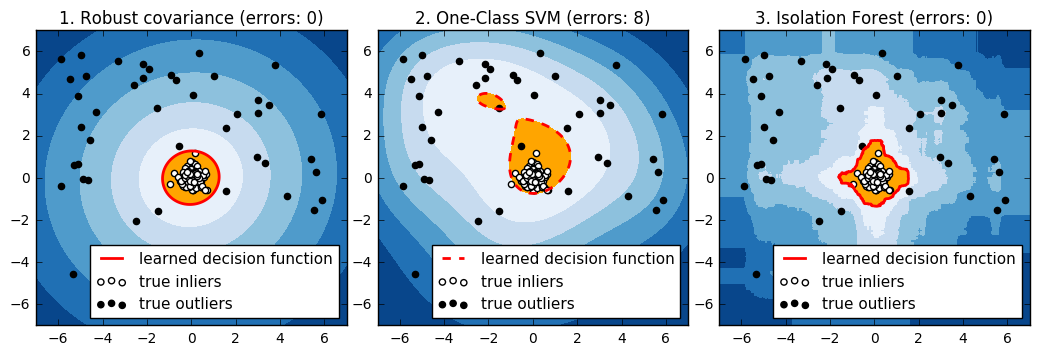

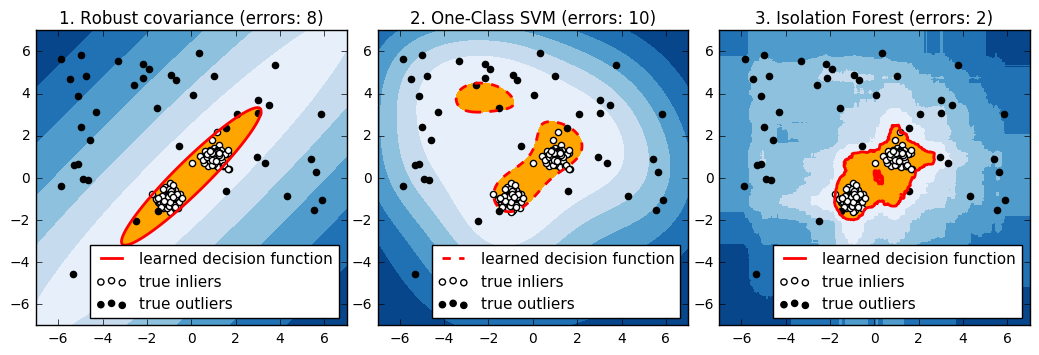

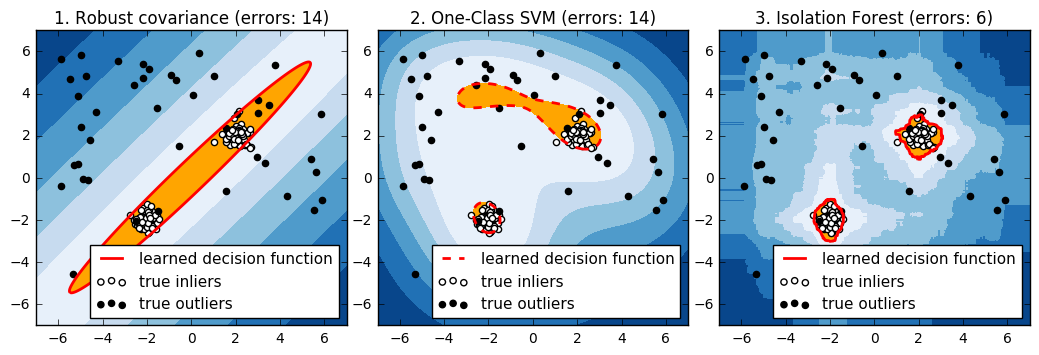

In [43]:
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # データの作成
    X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
    X = np.r_[X1, X2]
    # outlinerも追加
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]
    
    # トレーニング
    plt.figure(figsize=(10.8, 3.6))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        threshold = stats.scoreatpercentile(scores_pred, 100 * outliers_fraction)
        y_pred = clf.predict(X)
        n_errors = (y_pred != ground_truth).sum()
        
        # プロット
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(1, 3, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                                      cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold], linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=11),
            loc='lower right')
        subplot.set_title("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.92, 0.1, 0.26)

plt.show()